In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
# from scipy.stats import norm
import pyarrow.parquet as pq
import pandas as pd
from collections import namedtuple

/Users/arjunshah/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Loading in data and prepping for analysis

In [2]:
# Read in parquet file 
# table = pq.read_table("/Users/167011/Documents/MQF/Thesis/Deribit_Data/deribit_options_2025-01-30_100k_rows.parquet")

table = pq.read_table("/Users/arjunshah/Documents/UTS/Thesis/neural-sdes/data/deribit_options_2025-01-30_100k_rows.parquet")
# Convert to Panadas DataFrame
df = table.to_pandas()

# Seperate Option Type, Strike and Maturity
df[['asset', 'expiry', 'strike', 'option_type']] = df['instrument_name'].str.split('-', expand=True)

# Define log-price to ensure positive values
df['log_price'] = np.log(df['underlying_price'])
# Define log-return
df['log_return'] = df['log_price'].diff().fillna(0)
# Define mid-price
df['mid_price'] = ((df['best_bid_price'] + df['best_ask_price']) / 2) 


# Define maturity in years
df['expiry'] = pd.to_datetime(df['expiry'])
reference_date = pd.to_datetime("2025-01-30")
df['time_to_maturity'] = (df['expiry'] - reference_date).dt.days / 365.25 # Cryptocurrency is traded 24/7

# Convert strike to numeric
df['strike'] = pd.to_numeric(df['strike'], errors='coerce')
# Normalise strike
df['strike'] = df['strike'] / df['underlying_price']

# Group the DataFrame by 'time_stamp' and count unique 'time_to_maturity' values for each group
unique_counts = df.groupby('timestamp')['strike'].nunique()

# Identify the timestamp with the highest count of unique 'time_to_maturity' values
max_timestamp = unique_counts.idxmax()
max_count = unique_counts[max_timestamp]

# Snapshot where the count of unique 'time_to_maturity' values is highest
snapshot = df[(df['timestamp'] == max_timestamp) & (df['option_type'] == 'C')]

# Filter snapshot for open interest >0
snapshot = snapshot[snapshot['open_interest'] > 0]

# Convert 'strike' to numeric
# snapshot['strike'] = pd.to_numeric(snapshot['strike'], errors='coerce')

snapshot['mid_price'] = ((snapshot['best_bid_price'] + snapshot['best_ask_price']) / 2) # *snapshot['index_price']
snapshot['mark_price_usd'] = snapshot['mark_price']*snapshot['index_price']

snapshot = snapshot[['time_to_maturity', 'strike', 'mid_price', 'mark_price_usd', 'underlying_price', 'timestamp']]

# print(snapshot)

options_df = snapshot.copy()

options_df['maturity'] = options_df['time_to_maturity']
options_df['mid_market'] = options_df['mid_price'] 
options_df['underlying'] = options_df['underlying_price']
# options_df['strike'] = options_df['strike']/ options_df['underlying']
options_df['strike'] = options_df['strike']




options_df = options_df[['maturity', 'strike', 'mid_market', 'underlying', 'timestamp']]

print(options_df)

options_df = options_df.astype({
    'maturity': 'float32',
    'strike': 'float32',
    'mid_market': 'float32',
    'underlying': 'float32',
    'timestamp': 'datetime64[ns]'
})

print(options_df)

       maturity    strike  mid_market  underlying               timestamp
31951  0.156057  1.229879     0.02750   105701.43 2025-01-30 00:43:27.829
31959  0.156057  1.419091     0.01150   105701.43 2025-01-30 00:43:27.829
31961  0.156057  1.513688     0.00800   105702.11 2025-01-30 00:43:27.829
31963  0.156057  1.608304     0.00600   105701.43 2025-01-30 00:43:27.829
31965  0.156057  1.655607     0.00515   105701.43 2025-01-30 00:43:27.829
31967  0.156057  1.702910     0.00455   105701.43 2025-01-30 00:43:27.829
31969  0.156057  1.892122     0.00270   105701.43 2025-01-30 00:43:27.829
31973  0.156057  2.365152     0.00140   105701.43 2025-01-30 00:43:27.829
31975  0.156057  2.838183     0.00075   105701.43 2025-01-30 00:43:27.829
31977  0.405202  0.183983     0.81650   108705.69 2025-01-30 00:43:27.829
31979  0.405202  0.275975     0.72550   108705.69 2025-01-30 00:43:27.829
31981  0.405202  0.367966     0.63525   108705.69 2025-01-30 00:43:27.829
31983  0.405202  0.413962     0.59025 

/var/folders/mp/_m7_15bd59q6ry66dn_mvmvh0000gn/T/ipykernel_92161/3607704161.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expiry'] = pd.to_datetime(df['expiry'])


In [3]:
print(df[['strike', 'time_to_maturity', 'mid_price']])



         strike  time_to_maturity  mid_price
0      0.847634          0.000000    0.00000
1      0.847634          0.000000    0.00005
2      0.866898          0.000000    0.00000
3      0.866898          0.000000    0.00005
4      0.886162          0.000000    0.00000
...         ...               ...        ...
99995  0.787282          0.002738    0.21275
99996  0.787297          0.002738    0.00010
99997  0.796883          0.002738    0.20325
99998  0.796883          0.002738    0.00015
99999  0.806484          0.002738    0.19375

[100000 rows x 3 columns]


In [4]:
print(df.columns)

Index(['timestamp', 'state', 'index_price', 'instrument_name', 'last_price',
       'settlement_price', 'min_price', 'max_price', 'open_interest',
       'mark_price', 'best_ask_price', 'best_bid_price', 'interest_rate',
       'mark_iv', 'bid_iv', 'ask_iv', 'underlying_price', 'underlying_index',
       'best_ask_amount', 'best_bid_amount', 'estimated_delivery_price',
       'delivery_price', 'stats_high', 'stats_low', 'stats_price_change',
       'stats_volume', 'stats_volume_usd', 'greeks_delta', 'greeks_gamma',
       'greeks_rho', 'greeks_theta', 'greeks_vega', 'datetime', 'asset',
       'expiry', 'strike', 'option_type', 'log_price', 'log_return',
       'mid_price', 'time_to_maturity'],
      dtype='object')


In [5]:
price_history = df.copy()

# filter for >0 open interest
price_history = price_history[price_history['open_interest'] > 0]

# Filter for just calls
price_history = price_history[price_history['option_type'] == 'C']


# Normalised strke 
# price_history['strike'] = pd.to_numeric(price_history['strike'], errors='coerce')
# price_history['strike'] = price_history['strike'].values.astype('float32') / price_history['underlying_price']

# Filter for relevant columns
price_history = price_history[['timestamp', 'expiry', 'index_price', 'underlying_price','strike', 'best_bid_price', 'best_ask_price', 'mark_price', 'mid_price', 'time_to_maturity', 'option_type']]

price_history['time_to_maturity'] = price_history['time_to_maturity'].values.astype('float32')

# Sort by the 'timestamp' column in increasing order
price_history = price_history.sort_values(by='timestamp', ascending=True)

price_history['strike'] = price_history['strike'].astype('float32')

price_history = price_history.astype({
    'time_to_maturity': 'float32',
    'strike': 'float32',
    'mid_price': 'float32',
    'index_price': 'float32',
    'underlying_price': 'float32',
    'timestamp': 'datetime64[ns]'
})

print(price_history)

# print(len(price_history))

# print(price_history['strike'].value_counts())


                    timestamp     expiry    index_price  underlying_price  \
14    2025-01-30 00:00:58.943 2025-01-30  103795.437500     103818.437500   
18    2025-01-30 00:00:58.943 2025-01-30  103795.437500     103818.437500   
16    2025-01-30 00:00:59.032 2025-01-30  103795.437500     103820.195312   
22    2025-01-30 00:00:59.950 2025-01-30  103795.640625     103818.679688   
24    2025-01-30 00:00:59.950 2025-01-30  103795.640625     103818.679688   
...                       ...        ...            ...               ...   
99979 2025-01-30 02:11:04.862 2025-01-31  104057.281250     104156.453125   
99997 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99993 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99995 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99999 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   

         strike  best_bid_price  best_ask_price  mark_price  mid_price  \
1

In [6]:
print(df[df['strike'] == (1.2531230449676514)])
print(options_df[options_df['strike'] == (1.2531230449676514)])

Empty DataFrame
Columns: [timestamp, state, index_price, instrument_name, last_price, settlement_price, min_price, max_price, open_interest, mark_price, best_ask_price, best_bid_price, interest_rate, mark_iv, bid_iv, ask_iv, underlying_price, underlying_index, best_ask_amount, best_bid_amount, estimated_delivery_price, delivery_price, stats_high, stats_low, stats_price_change, stats_volume, stats_volume_usd, greeks_delta, greeks_gamma, greeks_rho, greeks_theta, greeks_vega, datetime, asset, expiry, strike, option_type, log_price, log_return, mid_price, time_to_maturity]
Index: []

[0 rows x 41 columns]
Empty DataFrame
Columns: [maturity, strike, mid_market, underlying, timestamp]
Index: []


In [7]:
print(price_history[price_history['strike'] == (1.2531230449676514)])
print(price_history.dtypes)

Empty DataFrame
Columns: [timestamp, expiry, index_price, underlying_price, strike, best_bid_price, best_ask_price, mark_price, mid_price, time_to_maturity, option_type]
Index: []
timestamp           datetime64[ns]
expiry              datetime64[ns]
index_price                float32
underlying_price           float32
strike                     float32
best_bid_price             float64
best_ask_price             float64
mark_price                 float64
mid_price                  float32
time_to_maturity           float32
option_type                 object
dtype: object


In [8]:
print(options_df.dtypes)

maturity             float32
strike               float32
mid_market           float32
underlying           float32
timestamp     datetime64[ns]
dtype: object


In [9]:
print(price_history)


                    timestamp     expiry    index_price  underlying_price  \
14    2025-01-30 00:00:58.943 2025-01-30  103795.437500     103818.437500   
18    2025-01-30 00:00:58.943 2025-01-30  103795.437500     103818.437500   
16    2025-01-30 00:00:59.032 2025-01-30  103795.437500     103820.195312   
22    2025-01-30 00:00:59.950 2025-01-30  103795.640625     103818.679688   
24    2025-01-30 00:00:59.950 2025-01-30  103795.640625     103818.679688   
...                       ...        ...            ...               ...   
99979 2025-01-30 02:11:04.862 2025-01-31  104057.281250     104156.453125   
99997 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99993 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99995 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   
99999 2025-01-30 02:11:05.870 2025-01-31  104055.179688     104155.882812   

         strike  best_bid_price  best_ask_price  mark_price  mid_price  \
1

In [10]:
# Strike finder helper function
def find_strike_matches(df, strike_col, target_strike, min_rows=5, max_precision=6):
    # First try exact match
    exact_match = df[df[strike_col] == target_strike]
    if len(exact_match) >= min_rows:
        return exact_match

    # Gradually reduce decimal precision
    for precision in range(max_precision, 0, -1):
        rounding_factor = 10 ** -precision
        lower = np.floor(target_strike / rounding_factor) * rounding_factor
        upper = lower + rounding_factor
        approx_match = df[(df[strike_col] >= lower) & (df[strike_col] <= upper)]
        if len(approx_match) >= min_rows:
            return approx_match

# This is the Neural SDE model with a generative adversarial network calibration method

Epoch 0: T=0.15605749189853668: RobustGenLoss=0.0028, T=0.40520191192626953: RobustGenLoss=0.0162
Epoch 5: T=0.15605749189853668: RobustGenLoss=0.0000, T=0.40520191192626953: RobustGenLoss=0.0029
Epoch 10: T=0.15605749189853668: RobustGenLoss=0.0001, T=0.40520191192626953: RobustGenLoss=0.0001
Epoch 15: T=0.15605749189853668: RobustGenLoss=0.0001, T=0.40520191192626953: RobustGenLoss=0.0007
Epoch 20: T=0.15605749189853668: RobustGenLoss=0.0001, T=0.40520191192626953: RobustGenLoss=0.0008
Epoch 25: T=0.15605749189853668: RobustGenLoss=0.0001, T=0.40520191192626953: RobustGenLoss=0.0005
Epoch 30: T=0.15605749189853668: RobustGenLoss=0.0001, T=0.40520191192626953: RobustGenLoss=0.0002
Epoch 35: T=0.15605749189853668: RobustGenLoss=0.0001, T=0.40520191192626953: RobustGenLoss=0.0001
Epoch 40: T=0.15605749189853668: RobustGenLoss=0.0001, T=0.40520191192626953: RobustGenLoss=0.0002
Epoch 45: T=0.15605749189853668: RobustGenLoss=0.0001, T=0.40520191192626953: RobustGenLoss=0.0001
Epoch 50: T=

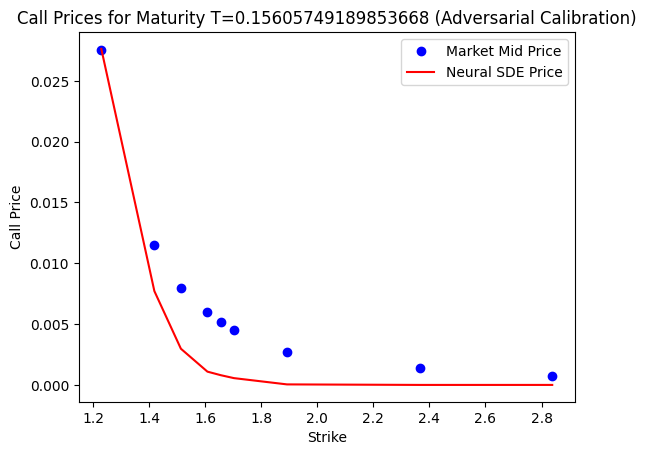

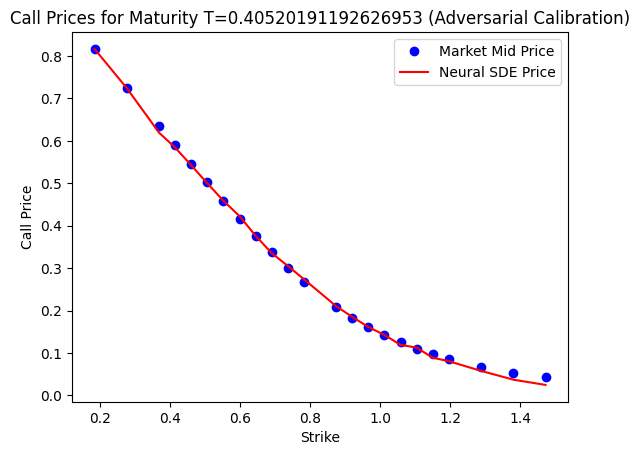

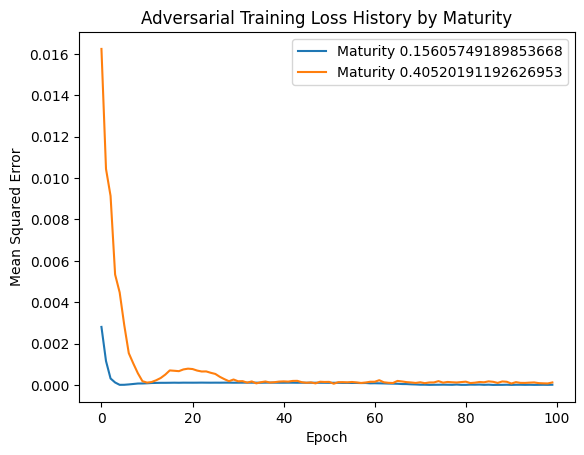

In [17]:
# Global model parameters
r = 0.00             # risk-free rate
nu = 0.5             # vol of vol
rho = -0.3           # correlation between dW and dB
alpha0 = 0.6         # initial stochastic vol level
# Underlying price (always 1.0 for normalized data)
S0 = np.float32(1)  # initial asset price
 

def build_leverage_model():
    model = models.Sequential()
    model.add(layers.Input(shape=(2,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='tanh'))
    model.add(layers.Lambda(lambda x: 2.0 + 2.0 * x))
    return model

unique_maturities = options_df['maturity'].unique()
leverage_models = {T: build_leverage_model() for T in unique_maturities}
optimizer_dict = {T: optimizers.Adam(learning_rate=0.01) for T in unique_maturities}

def bs_delta(S, K, T, r, sigma):
    d1 = (tf.math.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * tf.math.sqrt(T))
    norm_cdf = 0.5 * (1.0 + tf.math.erf(d1 / tf.sqrt(2.0)))
    return 0
    # return tf.exp(-r*T) * norm_cdf

# @tf.function
def simulate_S_paths(T, num_steps, num_paths, S0, sigma, leverage_model):
    dt = T / num_steps
    S = tf.fill([num_paths], S0)
    for i in range(num_steps):
        t_val = (i+1) * dt
        t_tensor = tf.fill([num_paths, 1], t_val)
        S_tensor = tf.reshape(S, (-1, 1))
        inp = tf.concat([t_tensor, S_tensor], axis=1)
        L_val = leverage_model(inp)
        L_val = tf.reshape(L_val, [-1])
        dW = tf.random.normal([num_paths], mean=0.0, stddev=tf.sqrt(dt))
        S = S + S * sigma * L_val * dW
    return S

# @tf.function
def monte_carlo_call_price(T, K, S0, r, sigma, leverage_model, num_steps=100, num_paths=5000):
    S_T = simulate_S_paths(T, num_steps, num_paths, S0, sigma, leverage_model)
    call_payoff = tf.nn.relu(S_T - K)
    delta = bs_delta(S_T, K, T, r, sigma)
    control_variate = delta * (S_T - S0)
    c = 1.0
    adjusted_payoff = call_payoff - c * control_variate
    price = tf.exp(-r * T) * tf.reduce_mean(adjusted_payoff)
    return price


# Robust loss function (min-max)
def robust_loss(model_price, price_history, num_candidates=int(4)):

    price_history = price_history.reset_index(drop=True)

    # if num_candidates is not None:
    #     # candidates = price_history['mid_price'].tail(num_candidates).values.astype('float32')
    #     candidates = price_history.iloc[-num_candidates:]['mid_price'].values.astype('float32')

    # else:
    #     candidates = price_history['mid_price'].values.astype('float32')

    # candidates = price_history['mid_price'].tail(4).values.astype('float32')
    
    candidates = price_history['mid_price'].values.astype('float32')
    candidate_losses = [tf.square(model_price - cand) for cand in candidates]
    return tf.reduce_max(tf.stack(candidate_losses))


num_epochs = 100
adv_loss_history = {T: [] for T in unique_maturities}

for epoch in range(num_epochs):
    loss_total_by_T = {T: 0.0 for T in unique_maturities}
    count_by_T = {T: 0 for T in unique_maturities}
    gen_loss_dict = {}
    with tf.GradientTape(persistent=True) as tape_gen:
        for idx, row in options_df.iterrows():
            T = float(row['maturity'])
            K = float(row['strike'])
            market_price = float(row['mid_market'])
            model_net = leverage_models[T]
            # Gain historical prices for the same (T,K)
            current_time = row['timestamp']
            
            local_price_history = (price_history[price_history['timestamp'] < current_time]) # Filter for past prices

            # print(local_price_history)

            test = local_price_history
            

            local_price_history = local_price_history[local_price_history['time_to_maturity'] == (T)] # Filter for same maturity

            local_price_history = find_strike_matches(local_price_history, 'strike', K)
                   
            # Get model price
            model_price = monte_carlo_call_price(
                T, K, S0, r, alpha0, model_net,
                num_steps=100, num_paths=1000
            )
            option_loss = robust_loss(model_price, local_price_history, market_price)
            # print(option_loss)
            loss_total_by_T[T] += option_loss
            count_by_T[T] += 1
        for T in unique_maturities:
            if count_by_T[T] > 0:
                loss_total_by_T[T] /= count_by_T[T]
            gen_loss_dict[T] = loss_total_by_T[T]

    for T in unique_maturities:
        model = leverage_models[T]
        grads_gen = tape_gen.gradient(gen_loss_dict[T], model.trainable_variables)
        optimizer_dict[T].apply_gradients(zip(grads_gen, model.trainable_variables))
        adv_loss_history[T].append(gen_loss_dict[T].numpy())
    del tape_gen

    if epoch % 5 == 0:
        losses_str = ", ".join(
            [f"T={T}: RobustGenLoss={gen_loss_dict[T].numpy():.4f}"
             for T in unique_maturities]
        )
        print(f"Epoch {epoch}: {losses_str}")

model_prices = []
for idx, row in options_df.iterrows():
    T = float(row['maturity'])
    K = float(row['strike'])
    model_net = leverage_models[T]
    price = monte_carlo_call_price(
        T, K, S0, r, alpha0, model_net,
        num_steps=100, num_paths=5000
    )
    model_prices.append(price.numpy())

options_df['model_price'] = model_prices
 
# Plot calibration results (market vs. model prices) for each maturity.
for T_val in options_df['maturity'].unique():
    subset = options_df[options_df['maturity'] == T_val]
    plt.figure()
    plt.plot(subset['strike'], subset['mid_market'], 'bo', label='Market Mid Price')
    plt.plot(subset['strike'], subset['model_price'], 'r-', label='Neural SDE Price')
    plt.title(f'Call Prices for Maturity T={T_val} (Adversarial Calibration)')
    plt.xlabel('Strike')
    plt.ylabel('Call Price')
    plt.legend()
    plt.show()
 
# Plot training loss history for each maturity.
plt.figure()
for T in unique_maturities:
    plt.plot(adv_loss_history[T], label=f'Maturity {T}')
plt.title("Adversarial Training Loss History by Maturity")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()

plt.show()



In [ ]:
print(test[(test['time_to_maturity'] == 0.15605749189853668) & (test['strike'] == 0.4139617681503296)])
test_2 = test[(test['time_to_maturity'] == 0.40520191192626953)]
print(test_2[(test_2['strike'] >= 0.413) & (test_2['strike'] <= 0.414)]['strike'].value_counts())

Empty DataFrame
Columns: [timestamp, expiry, index_price, underlying_price, strike, best_bid_price, best_ask_price, mark_price, mid_price, time_to_maturity, option_type]
Index: []
strike
0.413877    1
0.413761    1
0.413978    1
0.413963    1
0.413815    1
0.413984    1
Name: count, dtype: int64


In [144]:
print(test_2)

                    timestamp     expiry    index_price  underlying_price  \
492   2025-01-30 00:01:24.118 2025-03-28  103761.500000     105749.867188   
498   2025-01-30 00:01:24.118 2025-03-28  103761.500000     105747.367188   
496   2025-01-30 00:01:24.118 2025-03-28  103761.500000     105749.867188   
494   2025-01-30 00:01:24.118 2025-03-28  103761.500000     105749.867188   
490   2025-01-30 00:01:24.118 2025-03-28  103761.500000     105747.367188   
...                       ...        ...            ...               ...   
31937 2025-01-30 00:43:25.815 2025-03-28  103741.960938     105702.570312   
31949 2025-01-30 00:43:26.822 2025-03-28  103741.492188     105702.218750   
31953 2025-01-30 00:43:26.822 2025-03-28  103741.492188     105702.218750   
31955 2025-01-30 00:43:26.822 2025-03-28  103741.492188     105702.218750   
31957 2025-01-30 00:43:26.822 2025-03-28  103741.492188     105702.218750   

         strike  best_bid_price  best_ask_price  mark_price  mid_price  \
4